<a href="https://colab.research.google.com/github/Raziel-JKM/Finance_AI/blob/main/Code/FAI_Lec_13_1_%E1%84%8B%E1%85%A1%E1%86%BC%E1%84%89%E1%85%A1%E1%86%BC%E1%84%87%E1%85%B3%E1%86%AF%E1%84%80%E1%85%AA_%E1%84%8C%E1%85%AE%E1%84%80%E1%85%A1%E1%84%89%E1%85%AE%E1%84%8B%E1%85%B5%E1%86%A8%E1%84%85%E1%85%B2%E1%86%AF_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_exAPIKey_ipynb_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAI Lec 13-1 앙상블과 주가수익률 예측

금융AI

중앙대학교 금융공학

유시용 (sy61@cau.ac.kr)

본 코드는 중앙대학교 금융공학융합전공의 "금융AI"과목과 KMOOC(http://www.kmooc.kr/)의 "금융AI"과목에 사용된 코드입니다. 출처를 밝히셔도 되고, 자유롭게 사용하셔도 됩니다. 

## Preparing data


## 한국은행 포탈을 통해서 환율과 이자율 데이터를 다운 받기 (일별자료)
http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=main
1. 위의 한국은행 api 포탈링크를 누른후 "OPEN API 인증 신청" 버튼을 누르기  

2. 화면에 나오는 절차에 따라 API키를 받기위한 회원가입 진행하기 (회원가입을  완료하면 OPEN API 키가 생성됨.)  

3. 앞서 회원가입한 아이디로 로그인 하기  

4. 로그인 완료후 마이페이지를 누르면 아래와 같이 OPEN API 키를 확인 할 수 있으며, 이를 이용하면됨.
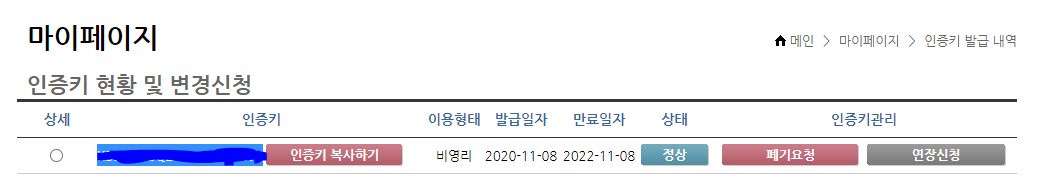


### 통계코드검색 페이지에서 통계코드를 검색.
5. https://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=guideStatCd&menuGroup=MENU000004&menuCode=MENU000024  


- 8.8.1.1 주요국통화의 대원화 환율[036Y001] - 원/미국달러(매매기준율)[0000001][원]


- 4.1.1 시장금리(일별)[060Y001]- KORIBOR(3개월)[010150000][연%], CD(91일)[010502000][연%]

6. 원하는 정보를 요청하는 url로 request하기

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

In [ ]:
import requests
import json
import xml.etree.ElementTree as ET
import csv
import pandas as pd

# API를 이용하여 data를 가져오는 함수
#   Input list
#       APIkey: http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=main 에서 발급받은 APIkey 사용자 인증키
#       requestType: API를 사용했을때 결과값 데이터의 형식, xml vs json, 하지만 아래 함수에서는 xml형식의 데이터를 파싱하는 코드로 작성함.
#       requestStartNum: 요청시작건수
#       requestFinishNum: 요청종료건수
#       statisticalTableCode: 8.8.1.1의 경우 036Y001
#                             4.1.1의 경우 060Y001
#       period: 주기, YY,MM,DD 
#       startDate: 검색시작일자
#       finishDate: 검색종료일자
#       statisticalItemCode: 통계항목코드, 최대3가지 입력가능. 
#                            8.8.1.1 원/달러 환율의 경우 "0000001"
#                            4.1.1 KORIBOR(3개월)의 경우 "010150000"
#                            4.1.1 CD(91일)의 경우 "010502000"
def getData(APIkey,requestType,requestStartNum,requestFinishNum,statisticalTableCode,period,startDate,finishDate,statisticalItemCode):
  url="http://ecos.bok.or.kr/api/StatisticSearch/"+APIkey+"/"+requestType+"/kr/"+requestStartNum+"/"+requestFinishNum+"/"+statisticalTableCode+"/"+period+"/"+startDate+"/"+finishDate+"/"+statisticalItemCode+"/?/?"
  print(url)
  response = requests.get(url)

  if response.status_code == 200 : #api로 응답을 받았는지 확인
    try : 
        contents = response.text
        ecosRoot = ET.fromstring(contents) # xml 타입의 데이터로 변경

        if ecosRoot[0].text[:4] in ('INFO','ERRO'):
            #호출결과에 오류가 있었는지 확인
            print("wrong!")
            print(ecosRoot[0].text + " : "+ ecosRoot[1].text)
        else:
            #이상이 없으면 결과값을 활용해서 필요한 프로그램 작성
            exchangeRates=[] #환율정보를 저장할 list를 초기화한다.
            iter_element=ecosRoot.iter(tag="row") # <row> 태그만을 찾아서 순회
            for element in iter_element: #"row"태그를 순회한다
                exchangeRate=[element.find("TIME").text,element.find("DATA_VALUE").text] #해당하는 값을 찾아서 list로 추가
                exchangeRates.append(exchangeRate)
            df=pd.DataFrame(exchangeRates,columns=['TIME','DATA_VALUE'])#list 형식의 데이터를 dataframe으로 변환
            #print("test : ",df)
            output_file="API_"+ statisticalTableCode+"_"+statisticalItemCode+".csv" #API_통계표코드_통계항목코드.csv의 이름으로 파일저장
            df.to_csv(output_file) # csv파일로 저장
            return df #데이터 프레임 타입의 데이터를 반환한다.
    except Exception as e:
        print(str(e)) #예외 오류가 발생했을때 처리


In [ ]:
# 위에서 만든 본인의 OPEN API KEY를 myAPIkey 변수의 저장
# ex) myAPIkey = "1234566789abcdedf" 
#myAPIkey = "[본인의 키를 입력하여 주세요]"
myAPIkey = "NGY0D21YWDMZNTM7DF86" 

#8.8.1.1 주요국통화의 대원화 환율[036Y001] - 원/미국달러(매매기준율)[0000001][원]
df_exchangeRate=getData(APIkey=myAPIkey,
            requestType="xml",
            requestStartNum="1",
            requestFinishNum="2682",
            statisticalTableCode="036Y001",
            period="DD",
            startDate="20100101",
            finishDate="20201031",
            statisticalItemCode="0000001")
print(df_exchangeRate)

#4.1.1 시장금리(일별)[060Y001]- KORIBOR(3개월)[010150000][연%]
df_KORIBOR=getData(APIkey=myAPIkey,
            requestType="xml",
            requestStartNum="1",
            requestFinishNum="2682",
            statisticalTableCode="060Y001",
            period="DD",
            startDate="20100101",
            finishDate="20201031",
            statisticalItemCode="010150000")
print(df_KORIBOR)

#4.1.1 시장금리(일별)[060Y001]- CD(91일)[010502000][연%]
df_CD=getData(APIkey=myAPIkey,
            requestType="xml",
            requestStartNum="1",
            requestFinishNum="2682",
            statisticalTableCode="060Y001",
            period="DD",
            startDate="20100101",
            finishDate="20201031",
            statisticalItemCode="010502000")
print(df_CD)

http://ecos.bok.or.kr/api/StatisticSearch/NGY0D21YWDMZNTM7DF86/xml/kr/1/2682/036Y001/DD/20100101/20201031/0000001/?/?
          TIME DATA_VALUE
0     20100104     1167.6
1     20100105     1156.2
2     20100106     1144.3
3     20100107     1138.2
4     20100108     1133.2
...        ...        ...
2677  20201026     1134.6
2678  20201027     1129.1
2679  20201028     1127.6
2680  20201029     1129.3
2681  20201030     1133.4

[2682 rows x 2 columns]
http://ecos.bok.or.kr/api/StatisticSearch/NGY0D21YWDMZNTM7DF86/xml/kr/1/2682/060Y001/DD/20100101/20201031/010150000/?/?
          TIME DATA_VALUE
0     20100104       2.86
1     20100105       2.87
2     20100106       2.87
3     20100107       2.88
4     20100108       2.88
...        ...        ...
2677  20201026       0.64
2678  20201027       0.64
2679  20201028       0.64
2680  20201029       0.64
2681  20201030       0.64

[2682 rows x 2 columns]
http://ecos.bok.or.kr/api/StatisticSearch/NGY0D21YWDMZNTM7DF86/xml/kr/1/2682/060Y001/DD/

In [ ]:
# 한국은행 API를 이용해 가져온 data의 포맷을 'float64'로 바꿔준다.

df_exchangeRate['DATA_VALUE'] = df_exchangeRate['DATA_VALUE'].astype('float64')
df_KORIBOR['DATA_VALUE'] = df_KORIBOR['DATA_VALUE'].astype('float64')
df_CD['DATA_VALUE'] = df_CD['DATA_VALUE'].astype('float64') 

In [ ]:
df_KORIBOR.head()

,TIME,DATA_VALUE
0,20100104,2.86
1,20100105,2.87
2,20100106,2.87
3,20100107,2.88
4,20100108,2.88


In [ ]:
# 후에 다운받을 야후의 주가 data와 동일한 형태로 만들기 위하여 한국은행 API를 이용해 가져온 data의 날짜 인덱스 명을 Date로 바꿔준다.

df_exchangeRate.rename(columns = {'TIME' : 'Date'}, inplace = True)
df_KORIBOR.rename(columns = {'TIME' : 'Date'}, inplace = True)
df_CD.rename(columns = {'TIME' : 'Date'}, inplace = True)

In [ ]:
df_exchangeRate.head()

,Date,DATA_VALUE
0,20100104,1167.6
1,20100105,1156.2
2,20100106,1144.3
3,20100107,1138.2
4,20100108,1133.2


In [ ]:
# 후에 다운받을 야후의 주가 data와 동일한 형태로 만들기 위하여 날짜의 형태를 yyyy-mm-dd 형태로 바꿔준다.
# 아직 Data가 인덱스는 아님 

df_exchangeRate['Date'] = pd.to_datetime(df_exchangeRate.Date)
df_KORIBOR['Date'] = pd.to_datetime(df_KORIBOR.Date)
df_CD['Date'] = pd.to_datetime(df_CD.Date)

In [ ]:
df_exchangeRate.head()

,Date,DATA_VALUE
0,2010-01-04,1167.6
1,2010-01-05,1156.2
2,2010-01-06,1144.3
3,2010-01-07,1138.2
4,2010-01-08,1133.2


In [ ]:
# 인덱스를 Date로 지정해준다. 

df_exchangeRate.set_index('Date', inplace=True)
df_KORIBOR.set_index('Date', inplace=True)
df_CD.set_index('Date', inplace=True)

In [ ]:
df_exchangeRate.head()

,DATA_VALUE
Date,
2010-01-04,1167.6
2010-01-05,1156.2
2010-01-06,1144.3
2010-01-07,1138.2
2010-01-08,1133.2


In [ ]:
# 데이터를 다운 받을 기간을 설정
# 앞서 API 데이터를 받은 기간과 동일하게 설정하기
start = datetime(2010,1,1)
end = datetime(2020,10,31)

NameError: ignored

In [ ]:
start

NameError: ignored

In [ ]:
!pip install pandas-datareader

In [ ]:
# 주가 데이터를 다운 받아주세요. 

ksp = pdr.DataReader('^KS11','yahoo',start,end) # KOSPI
ss = pdr.DataReader('005930.KS','yahoo',start,end) # 삼성전자
hm = pdr.DataReader('005380.KS','yahoo',start,end) # 현대차 
snp = pdr.DataReader('^GSPC','yahoo',start,end) #S&P500
nki = pdr.DataReader('^N225','yahoo',start,end) # Nikkei 225
uxt = pdr.DataReader('^N100','yahoo',start,end) # EURONEXT 100
vix = pdr.DataReader('^VIX','yahoo',start,end) # VIX

NameError: ignored

In [ ]:
ksp.shape

In [ ]:
snp.shape

In [ ]:
ss.head()

In [ ]:
ksp.tail()

In [ ]:
snp.head()

In [ ]:
vix.tail()

In [ ]:
# 분석을 위해서 수정종가를 따로 모으고 이것들과 환율 및 시장금리 데이터를 합치도록 한다.

stk = pd.DataFrame({
    'ss': ss['Close'], # 삼성전자의 경우, yahoo finance 수정종가가 좀 이상해서 그냥 종가를 사용하도록 함 
    'hm': hm['Adj Close'],
    'ksp': ksp['Adj Close'],
    'snp': snp['Adj Close'],
    'nki': nki['Adj Close'],
    'uxt': uxt['Adj Close'],
    'vix': vix['Adj Close'],
    'exr': df_exchangeRate['DATA_VALUE'],
    'koribor': df_KORIBOR['DATA_VALUE'],
    'cd': df_CD['DATA_VALUE']
}).dropna()
# dropna : 결측치를 처리하는 함수. 결측치란 값이 없는 것을 말한다. 만약 2020-10-26 에 삼성의 종가 값이 없다면 그 행을 통째로 삭제한다.


In [ ]:
stk

In [ ]:
# 연속시간 수익률 (로그 차분)
rtn= ( np.log(stk) - np.log(stk.shift(1)) )*100 
# np.log() 데이터프레임의 모든 값을 log를 취한다
# stk.shift(1) stk데이터프레임에서 데이터를 한행씩 아래로 미룬다.
rtn.columns=['r_ss' ,'r_hm','r_ksp','r_snp','r_nki','r_uxt','r_vix','r_exr','r_koribor','r_cd'] # 새로운 컬럼명으로 데이터프레임 생성


In [ ]:
rtn.head()

In [ ]:
# Momentum의 대리변수로 1개월, 3개월, 6개월, 12개월 간의 수익률을 계산함 
# (모멘텀: 주가 수익률의 상승세 정도 혹은 추이를 의미해요)

# pct_change() 수익률을 계산하는 함수. 
# 어제 종가가 10000원이었고 오늘 12000원일때
# 하루동안 수익률은 (12000-10000)/10000으로 계산함.
# period는 수익률을 계산하고자 하는 기간
# 100을 곱하면 단위가 %로 변한다.

# 모멘텀 계산 시, 시점 주의할 것: 현재 시점 포함시키면 곤란함 

stklag=stk.shift(1) # 어제부터 시작해서 과거로 일정기간 설정 (오늘 시점은 변수, not obs)
stklag

stk_1d = stklag.pct_change()*100   # 1일 전의 수익률을 계산해서 dataframe을 생성하고
stk_1d.columns = ['%s_1d'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_2d = stklag.pct_change(periods=2)*100   # 2일 간의 수익률을 계산해서 dataframe을 생성하고
stk_2d.columns = ['%s_2d'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_3d = stklag.pct_change(periods=3)*100   # 3일 간의 수익률을 계산해서 dataframe을 생성하고
stk_3d.columns = ['%s_3d'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_4d = stklag.pct_change(periods=4)*100   # 4일 간의 수익률을 계산해서 dataframe을 생성하고
stk_4d.columns = ['%s_4d'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_1w = stklag.pct_change(periods=5)*100   # 5일 간의 수익률을 계산해서 dataframe을 생성하고
stk_1w.columns = ['%s_1w'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_2w = stklag.pct_change(periods=10)*100   # 10일 간의 수익률을 계산해서 dataframe을 생성하고
stk_2w.columns = ['%s_2w'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_1m = stklag.pct_change(periods=20)*100   # 20일 간의 수익률을 계산해서 dataframe을 생성하고
stk_1m.columns = ['%s_1m'%col for col in stk.columns] # dataframe의 컬럼명을 설정

stk_3m = stklag.pct_change(periods=60)*100   # 60일
stk_3m.columns = ['%s_3m'%col for col in stk.columns]

stk_6m = stklag.pct_change(periods=120)*100   # 120일 
stk_6m.columns = ['%s_6m'%col for col in stk.columns]

stk_12m = stklag.pct_change(periods=240)*100   # 240일 
stk_12m.columns = ['%s_12m'%col for col in stk.columns]

In [ ]:
stk_3d.head()

NameError: ignored

In [ ]:
stk_12m.head()

In [ ]:
# 모멘텀 데이터를 합해주세요. join함수 사용

stk_m = stk_1d.join(stk_2d)\
    .join(stk_3d)\
    .join(stk_4d)\
    .join(stk_1w)\
    .join(stk_2w)\
    .join(stk_1m)\
    .join(stk_3m)\
    .join(stk_6m)\
    .join(stk_12m)\
    .dropna() 

stk_m.head()

In [ ]:
stk_m.columns

## Preparing target and feature variables

In [ ]:
# target 종속변수 
# 여기서는 일단 삼성전자 주가 수익률 
#y = rtn['r_ss']

In [ ]:
# Lag 시킬 features 

#x0=pd.DataFrame({
#    'r_ss_lag':rtn['r_ss'], #  바로 다음 코드에서 lag 할 예정 : target variable의 serial dependence 를 파악하기 위해서 
#    'r_hm':rtn['r_hm'],
#    'r_ksp':rtn['r_ksp'],
#    'r_nki':rtn['r_nki'],
#    'ss_1w':stk_m['ss_1w'],
#    'hm_1w':stk_m['hm_1w'],
#    'ksp_1w':stk_m['ksp_1w'],
#    'nki_1w':stk_m['nki_1w'],
#    'ss_2w':stk_m['ss_2w'],
#    'hm_2w':stk_m['hm_2w'],
#    'ksp_2w':stk_m['ksp_2w'],
#    'nki_2w':stk_m['nki_2w'],    
#    'ss_1m':stk_m['ss_1m'],
#    'hm_1m':stk_m['hm_1m'],
#    'ksp_1m':stk_m['ksp_1m'],
#    'nki_1m':stk_m['nki_1m'],
#'ss_3m':stk_m['ss_3m'],
#'hm_3m':stk_m['hm_3m'],
#'ksp_3m':stk_m['ksp_3m'],
#'nki_3m':stk_m['nki_3m'],
#'ss_6m':stk_m['ss_6m'],
#'hm_6m':stk_m['hm_6m'],
#'ksp_6m':stk_m['ksp_6m'],
#'nki_6m':stk_m['nki_6m'],
#    'exr': stk['exr'],      # 수준 변수 사용 
#    'koribor': stk['koribor'], # 수준 변수 사용 
#    'cd': stk['cd'],          # 수준 변수 사용 
#}).dropna()  
#x0             

In [ ]:
# 해외주식의 경우, 
#xnolag=pd.DataFrame({
#    'r_snp':rtn['r_snp'],
#    'r_uxt':rtn['r_uxt'],
#    'snp_1w':stk_m['snp_1w'],
#    'uxt_1w':stk_m['uxt_1w'],
#    'snp_2w':stk_m['snp_2w'],
#    'uxt_2w':stk_m['uxt_2w'],
#    'snp_1m':stk_m['snp_1m'],
#    'uxt_1m':stk_m['uxt_1m'],
#'snp_3m':stk_m['snp_3m'],
#'uxt_3m':stk_m['uxt_3m'],
#'snp_6m':stk_m['snp_6m'],
#'uxt_6m':stk_m['uxt_6m'],    
#    'vix': stk['vix']      # 수준 변수 사용 
#}).dropna()  
#xnolag  

In [ ]:
# x 설병면수이기 때문에, 하루 lag 시켜줌 
#xlag=x0.shift(1)
#xlag

In [ ]:
#stklag.rename(columns = {'exr' : 'exrlag'), inplace = True)
#stklag.rename(columns = {'cd' : 'cdlag'), inplace = True)
#stklag.rename(columns = {'koribor' : 'koriborlag'), inplace = True)

fifx=pd.DataFrame({
   'exr_lag':stklag['exr'],
   'koribor_lag':stklag['koribor'],
   'cd_lag':stklag['cd']
}).dropna()      

fifx 

In [ ]:
fifx1=fifx.shift() 
fifx1.columns=['exr_2lag','koribor_2lag','cd_2lag']
fifx1

In [ ]:
fifx2=fifx1.shift() 
fifx2.columns=['exr_3lag','koribor_3lag','cd_3lag']
fifx2

In [ ]:
# feature를 모아주세요. 

#x = xlag.join(xnolag)\
A = stk_m.join(stk)\
    .join(rtn)\
    .join(fifx)\
    .join(fifx1)\
    .join(fifx2)\
    .dropna()
A

In [ ]:
# target 선택

y = A['r_ss']
y

In [ ]:
# feature 선택: 일단 고려한 모든 변수들을 list 함

x=A[['ss_1d', 'hm_1d', 'ksp_1d', 
       'r_snp', 'r_uxt', 'vix',   # 해외 변수의 경우, 시차를 고려하여 래그를 하지 않을 수도 있음 
       'exr_lag', 'koribor_lag', 'cd_lag', # 수준변수 (lag): 환율, 금리 
       'exr_2lag', 'koribor_2lag', 'cd_2lag', # 수준변수 (lag 2): 환율, 금리 
       'exr_3lag', 'koribor_3lag', 'cd_3lag', # 수준변수 (lag 3): 환율, 금리 

       'snp_1d', 'nki_1d', 'uxt_1d', 'vix_1d',
       'exr_1d', 'koribor_1d', 'cd_1d', 
       'ss_2d', 'hm_2d', 'ksp_2d', 
       'snp_2d','nki_2d', 'uxt_2d', 'vix_2d', 
       'exr_2d', 'koribor_2d', 'cd_2d', 
       'ss_3d','hm_3d', 'ksp_3d', 
       'snp_3d', 'nki_3d', 'uxt_3d', 'vix_3d', 
       'exr_3d','koribor_3d', 'cd_3d', 
       'ss_4d', 'hm_4d', 'ksp_4d', 
       'snp_4d', 'nki_4d','uxt_4d','vix_4d', 
       'exr_4d', 'koribor_4d', 'cd_4d', 
       'ss_1w', 'hm_1w','ksp_1w', 
       'snp_1w', 'nki_1w', 'uxt_1w', 'vix_1w', 
       'exr_1w','koribor_1w', 'cd_1w', 
       'ss_2w', 'hm_2w', 'ksp_2w', 
       'snp_2w', 'nki_2w','uxt_2w', 'vix_2w', 
       'exr_2w', 'koribor_2w', 'cd_2w', 
       'ss_1m', 'hm_1m','ksp_1m', 
       'snp_1m', 'nki_1m', 'uxt_1m', 'vix_1m', 
       'exr_1m','koribor_1m', 'cd_1m', 
       'ss_3m', 'hm_3m', 'ksp_3m', 
       'snp_3m', 'nki_3m','uxt_3m', 'vix_3m', 
       'exr_3m', 'koribor_3m', 'cd_3m', 
       'ss_6m', 'hm_6m','ksp_6m', 
       'snp_6m', 'nki_6m', 'uxt_6m', 'vix_6m', 
       'exr_6m','koribor_6m', 'cd_6m', 
       'ss_12m', 'hm_12m', 'ksp_12m', 
       'snp_12m','nki_12m', 'uxt_12m', 'vix_12m', 
       'exr_12m', 'koribor_12m', 'cd_12m']]
     
x     

### 기초총계 확인

* #(features) 너무 많아 일정 변수만 선택해서 살펴보고자 함

In [ ]:
x_select = A[['r_ss','ss_1d', 'hm_1d', 'ksp_1d', 
       'r_snp', 'r_uxt', 'vix',   # 해외 변수의 경우, 시차를 고려하여 래그를 하지 않을 수도 있음 
       'exr_lag', 'koribor_lag', 'cd_lag', # 수준변수 (lag): 환율, 금리 
       'exr_2lag', 'koribor_2lag', 'cd_2lag', # 수준변수 (lag 2): 환율, 금리 
       'exr_3lag', 'koribor_3lag', 'cd_3lag'
    
]]
              
x_select

In [ ]:
df=x_select
stats = df.describe()
stats.loc['var'] = df.var().tolist()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
print(stats)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)
plt.subplots(figsize=(20,15))
sns.heatmap(x_select.corr(),annot=True,cmap="YlGnBu",fmt=".2f")

In [ ]:
sns.pairplot(x_select)

### 상관관계에서 발견된 점 
* 환율은 lag 값들과 상관관계가 여전히 높음
* koribor, cd : 상관관계 너무 높음
* target과 국내주식과의 상관관계는 낮음

In [ ]:
x_select2 = A[['r_ss',  
       'snp_1d', 'nki_1d', 'uxt_1d', 'vix_1d',
       'ss_2d', 'hm_2d', 'ksp_2d', 
       'snp_2d','nki_2d', 'uxt_2d', 'vix_2d', 
       'ss_3d','hm_3d', 'ksp_3d', 
       'snp_3d', 'nki_3d', 'uxt_3d', 'vix_3d', 
       'ss_4d', 'hm_4d', 'ksp_4d', 
       'snp_4d', 'nki_4d','uxt_4d','vix_4d', 
       'ss_1w', 'hm_1w','ksp_1w', 
       'snp_1w', 'nki_1w', 'uxt_1w', 'vix_1w', 
       'exr_1w'
    
]]
              
x_select2

In [ ]:
sns.set(font_scale=2)
plt.subplots(figsize=(20,15))
sns.heatmap(x_select2.corr(),annot=True,cmap="YlGnBu",fmt=".2f",annot_kws={"size": 14})

In [ ]:
x_select2.corr()

### 상관관계를 통한 발견점 
* target과 국내 주식의 모멘텀 변수는 상관관계 낮음
* target과 해외 주식의 모멘텀 변수는 상관관계 높음

In [ ]:
x_select3 = A[['r_ss',  
       'ss_1m', 'hm_1m','ksp_1m', 
       'snp_1m', 'nki_1m', 'uxt_1m', 'vix_1m', 
       'ss_3m', 'hm_3m', 'ksp_3m', 
       'snp_3m', 'nki_3m','uxt_3m', 'vix_3m', 
       'ss_6m', 'hm_6m','ksp_6m', 
       'snp_6m', 'nki_6m', 'uxt_6m', 'vix_6m' 
]]
              
x_select3

In [ ]:
sns.set(font_scale=2)
plt.subplots(figsize=(20,15))
sns.heatmap(x_select3.corr(),annot=True,cmap="YlGnBu",fmt=".2f",annot_kws={"size": 14})

In [ ]:
sns.pairplot(x_select3)

### 상관관계에서 발견된 점 
* target과 높은 상관관계를 보이는 feature가 없음

## feature seleciton 예시

In [ ]:
xy=A[['r_ss',
       'ss_1d', 'hm_1d', 'ksp_1d', 
       'r_snp', 'r_uxt', 'vix',   # 해외 변수의 경우, 시차를 고려하여 래그를 하지 않을 수도 있음 
       'exr_lag', 'koribor_lag', 'cd_lag', # 수준변수 (lag): 환율, 금리 
       'snp_1d', 'nki_1d', 'uxt_1d', 'vix_1d',
       'snp_2d','nki_2d', 'uxt_2d', 'vix_2d', 
       'snp_3d', 'nki_3d', 'uxt_3d', 'vix_3d', 
       'snp_4d', 'nki_4d','uxt_4d','vix_4d', 
       'snp_1w', 'nki_1w', 'uxt_1w', 'vix_1w', 
       'snp_2w', 'nki_2w','uxt_2w', 'vix_2w', 
       'snp_1m', 'nki_1m', 'uxt_1m', 'vix_1m', 
       'snp_3m', 'nki_3m','uxt_3m', 'vix_3m', 
       'snp_6m', 'nki_6m', 'uxt_6m', 'vix_6m', 
       'snp_12m','nki_12m', 'uxt_12m', 'vix_12m' 
    ]]
     
xy     

In [ ]:
xy.corr()

In [ ]:
# 최종적인 target과 features 결정 
y=xy['r_ss']
x= xy.drop(['r_ss'] ,1)
x

In [ ]:
y.describe()

In [ ]:
# 이제 선형회귀식을 추정해보아요. 
import statsmodels.api as sm

olsreg = sm.OLS(y, x)
result =olsreg.fit()
result.summary()

### feature selection
* 선형회귀 결과를 기반으로 features 선택
* 유의수준이 0.3 이하인 feature를 선택

In [ ]:
x=A[[
       'ss_1d','ss_2d','ss_3d','ss_4d','ss_1w','ss_2w', 
       'ksp_1d', 
       'r_snp', 'r_uxt', 'vix',   # 해외 변수의 경우, 시차를 고려하여 래그를 하지 않을 수도 있음 
       'snp_1d', 'uxt_1d', 
       'nki_2d', 
       'snp_2w', 'vix_2w', 
       
       'nki_4d', 
       'vix_1d', 'vix_4d', 'vix_6m', 'vix_12m'
    
    ]]
     
x

## Multi-asset linear regression

In [ ]:
# scikit-learn 패키지를 이용해서 선형회귀분석할때는 linear_model의 LinearRegression클래스를 사용해야함.
from sklearn.linear_model import LinearRegression
from datetime import datetime

class LinearRegressionModel(object):
    def __init__(self): #클래스에서 생성자
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False) 
        #LinearRegression 클래스 객체 생성
        # fit_intercept는 모형에 상수항이 없으면 False로 설정

    def learn(self, df, ys, start_date, end_date, lookback_period=20): # lookback_period : 추정에 사용하는 과거 데이터 수 
        model = self.get_model() # 바로 위의 get_model(self)함수 호출, 클래스 객체를 생성한다.

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period) 
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel()) #모델을 추정. 상수항 결합을 자동으로 해준다.

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current]) #모델로 값을 예측한다.

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred] #예측한값과 실제값을 self.df_result에 저장

    def get_prices_since(self, df, date_since, lookback):#데이터에서 날짜에 해당하는 값들만 추출하는 함수
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [ ]:
multi_linear_model = LinearRegressionModel() #LinearRegression 클래스 객체 생성
multi_linear_model.learn(x, y, start_date='2015-01-01', end_date='2020-10-31', lookback_period=420) # 모델을 학습시킨다

In [ ]:
multi_linear_model.df_result.plot(
    title='Actual versus Predicted percentage returns',
    style=['-', '--'], figsize=(12,8));
    #df_result으로 모델로 예측한값과 실제값이 얼마나 일치하는지 그래프로 그리기.

In [ ]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, 
    explained_variance_score, r2_score 
#    accuracy_score, precision_score, recall_score, f1_score 
)
# 모델을 검증하는 과정
def print_regression_metrics(df_result, result_df, name):
    actual = list(df_result['Actual']) # 실제값
    predicted = list(df_result['Predicted']) #예측값

    print(name)
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted)) # MAE, 모델의 예측값과 실제값의 차이를 모두 더해서 평균낸것
    print('mean_squared_error:', mean_squared_error(actual, predicted)) #MSE, 모델의 예측값과 실제값의 차이를 제곱해서 평균낸것
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted)) # 설명분산점수 Explained Variance Score
    print('r2_score:', r2_score(actual, predicted)) # 결정계수 R2
    
    new_data = {'Model name': name, 'Mean absolute error': mean_absolute_error(actual, predicted), 'Mean squared error': mean_squared_error(actual, predicted), 'Explained variance score': explained_variance_score(actual, predicted), 'R2 score': r2_score(actual, predicted)}
#    new_data = {'Model name': name, 'Mean absolute error': mean_absolute_error(actual, predicted), 'Mean squared error': mean_squared_error(actual, predicted), 'Explained variance score': explained_variance_score(actual, predicted), 'R2 score': r2_score(actual, predicted), 'Accuracy_score': accuracy_score(actual, predicted), 'Precision_score': precision_score(actual, predicted), 'recall_score': recall_score(actual, predicted),'f1_score': f1_score(actual, predicted)}
    result_df = result_df.append(new_data, ignore_index=True)

    return result_df


result_df = pd.DataFrame(index=range(0,0), columns=['Model name', 'Mean absolute error', 'Mean squared error', 'Explained variance score', 'R2 score'])

In [ ]:
print_regression_metrics(multi_linear_model.df_result, result_df, "Linear regressor")

## An ensemble of decision trees

### Bagging regressor

In [ ]:
# 앙상블 학습을 위해서 scikit-learn 패키지로부터 BaggingRegressor를 가져온다.
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  # n_estimators: 의사결정트리의 개수
                                                                  # 랜덤한 데이터 분할을 위한 시드값

In [ ]:
bagging = BaggingRegressorModel() # BaggingRegressorModel 객체 생성
bagging.learn(x, y, start_date='2015-01-01',  # 모델을 학습시킨다
              end_date='2020-10-31', lookback_period=420)

In [ ]:
result_df = print_regression_metrics(bagging.df_result, result_df, "Bagging regressor")

### Random forests regressor

In [ ]:
#  scikit-learn 패키지로부터 RandomForestRegressor를 가져온다.
from sklearn.ensemble import RandomForestRegressor
class RandomForestRegressorModel(LinearRegressionModel):
    def get_model(self):            
        return RandomForestRegressor(n_estimators=20, random_state=0) # n_estimators: 의사결정트리의 개수
                                                                      # 랜덤한 데이터 분할을 위한 시드값

In [ ]:
RandomForest = RandomForestRegressorModel() # GradientBoostingRegressorMode 객체 생성    
RandomForest.learn(x, y, start_date='2015-01-01', # 모델을 학습시킨다                 
    end_date='2020-10-31', lookback_period=420) 

In [ ]:
result_df = print_regression_metrics(RandomForest.df_result, result_df, "Random forests regressor")

### AdaBoost regressor

In [ ]:
# 앙상블 학습을 위해서 scikit-learn 패키지로부터 AdaBoostRegressor를 가져온다.
from sklearn.ensemble import AdaBoostRegressor

class AdaBoostRegressorModel(LinearRegressionModel):
    def get_model(self):
        return AdaBoostRegressor(n_estimators=20, random_state=0) # n_estimators: 의사결정트리의 개수
                                                                  # 랜덤한 데이터 분할을 위한 시드값

In [ ]:
adaBoost = AdaBoostRegressorModel() # AdaBoostRegressorModel 객체 생성
adaBoost.learn(x, y, start_date='2015-01-01',  # 모델을 학습시킨다
              end_date='2020-10-31', lookback_period=420)

In [ ]:
result_df = print_regression_metrics(adaBoost.df_result, result_df, "AdaBoost regressor")

### Gradient boosting regressor

In [ ]:
#  scikit-learn 패키지로부터 GradientBoostingRegressor를 가져온다.
from sklearn.ensemble import GradientBoostingRegressor
class GradientBoostingRegressorModel(LinearRegressionModel):
    def get_model(self):            
        return GradientBoostingRegressor(n_estimators=20, random_state=0) # n_estimators: 의사결정트리의 개수
                                                                          # 랜덤한 데이터 분할을 위한 시드값

In [ ]:
GradientBoosting = GradientBoostingRegressorModel() # GradientBoostingRegressorMode 객체 생성
GradientBoosting.learn(x, y, start_date='2015-01-1',  # 모델을 학습시킨다                  
    end_date='2020-10-31', lookback_period=420) 

In [ ]:
result_df = print_regression_metrics(GradientBoosting.df_result, result_df, "Gradient boosting regressor")

### 4가지 분류기(adaboost, agging, gradient boosting, random forest) 성능 비교

In [ ]:
result_df.set_index('Model name', inplace=True)
result_df